# Continuation analysis

## Contents.
* [Introduction](#intro)
* [Setup](#imports)
* [Functions](#functions)
* [Continuation on a](#a)
* [Continuation on b](#b)

## Introduction. <a class="anchor" id="intro"></a>

We take the system of ODEs of the 13-node network, but fixing the concentration at a steady-state solution $x(t\rightarrow\infty)=x^*$. Thus, the system depends no longer on time. 
Each equation in the system is equated to zero, i.e.,

$
    \dot{x}_i = F_i = 0,\;\; i=1,2,...,13. \label{eq:bifurcation}
$

We may call the right-hand side of the whole system of equations $F(\textbf{x})$, where $\textbf{x}$ is a vector of 13 node concentrations.
We do this to incrementally change one of the parameters and calculate the corresponding, new steady-state concentration $x^*$. For this, we need an initial condition on the steady-state $x^*_0$, which, in our case, corresponds to the steady states of the 13-node network, and a way to obtain new steady states iteratively. This is usually done by a Newton-type algorithm like

$
    x^*_{k+1} = x^*_k + J_k^{-1}F(x_k),\; \; k=0,1,...,
$

where $J$ is the Jacobian of the system $F(\textbf{x})$. By continuing these iterations until a threshold of the parameter---here we do the continuation of both parameters within values 0 and 1---, we can explore the space of possible attractors of the system when changing a parameter in the equations. All in all, we obtain a function of the steady-state concentrations on the analyzed parameter: $x^*(a)$ or $x^*(b)$. 

Since the system is bistable for the projection of NANOG and GATA6, it is enough to do the continuation on the concentration of only one of these nodes. In this notebook, we undertake the continuation of the steady-state concentration of NANOG.

## Setup. <a class="anchor" id="imports"></a>

In [1]:
# You can install a package with the next line of code:
# import Pkg; Pkg.add(Name_of_package)
# where Name_of_package is a string with the package name, e.g.
# import Pkg; Pkg.add("Revise")
using Revise, ForwardDiff, Parameters, Setfield, Plots, LinearAlgebra
using DifferentialEquations, Random, Distributions
using PyPlot
using PyCall
@pyimport matplotlib.patches as mpatches
using BifurcationKit
using LaTeXStrings
const BK = BifurcationKit;

We include the sparse matrix `m13` that describes the 13-node network (for more info on how we got this network, see notebook `1_Network_pruning`.

In [2]:
include("./Data/m13.txt");

Function to calculate the p-norm. We will use this in the continuation analysis.

In [3]:
norminf = x -> norm(x, Inf);

We use the same global parameters that guaranteed bistability of the GRN network (both for the original 52-node network, as well as the 13-node network).

In [4]:
param = (a=0.38, b = 0.5, n = 3. , S = 0.5 , k = 1.0);

## Functions <a class="anchor" id="functions"></a>

When trying to define the system of ODEs recursively (as we do in the rest of the notebooks), we found an issue by which the bifurcation analysis was not consistent. Hence, here we define the equations describing explicitly the 13-node network.

In [5]:
function act(x,a,n,S)
    return a.*x.^n./(S.^n.+x.^n)
end;

function repr(x,b,n,S)
    return b.*S.^n./(S.^n.+x.^n)
end;

In [6]:
function TMvf!(x,p,t)
    
    @unpack a, b, n, S, k = p
    
    dx1 = - k.*x[1] .+ act(x[3],a,n,S) .+ act(x[4],a,n,S) .+ repr(x[10],b,n,S)
    dx2 = - k.*x[2] .+ act(x[3],a,n,S) .+ act(x[4],a,n,S)
    dx3 = - k.*x[3] .+ act(x[3],a,n,S) .+ act(x[4],a,n,S) .+ act(x[5],a,n,S).+ act(x[6],a,n,S).+ act(x[7],a,n,S).+ repr(x[9],b,n,S)
    dx4 = - k.*x[4] .+ act(x[1],a,n,S) .+ act(x[2],a,n,S)
    dx5 = - k.*x[5] .+ act(x[1],a,n,S) .+ act(x[2],a,n,S) .+ act(x[3],a,n,S)
    dx6 = - k.*x[6] .+ act(x[2],a,n,S) .+ act(x[3],a,n,S)
    dx7 = - k.*x[7] .+ act(x[3],a,n,S)
    dx8 = - k.*x[8] .+ repr(x[1],b,n,S) .+ repr(x[3],b,n,S)
    dx9 = - k.*x[9] .+ repr(x[1],b,n,S) .+ repr(x[3],b,n,S) .+ repr(x[8],b,n,S) .+ act(x[9],a,n,S) .+ repr(x[12],b,n,S) .+ repr(x[13],b,n,S)
    dx10 = -k.*x[10] .+ repr(x[1],b,n,S) .+ repr(x[3],b,n,S) .+ act(x[10],a,n,S)
    dx11 = -k.*x[11]
    dx12 = -k.*x[12] .+ act(x[3],a,n,S) .+ repr(x[11],b,n,S)
    dx13 = - k.*x[13] .+ act(x[1],a,n,S) .+ act(x[2],a,n,S) .+ act(x[3],a,n,S)
    
    return [dx1,dx2,dx3,dx4,dx5,dx6,dx7,dx8,dx9,dx10,dx11,dx12,dx13]
    
end # ends function
;

The continuation requires the system to be fixed in time:

In [7]:
# Out of place method:
TMvf(z, p) = TMvf!(z, p, 0);

The Jacobian of the system is given by:

In [8]:
dTMvf = (z,p) -> ForwardDiff.jacobian(x -> TMvf(x,p), z);

# Continuation on a <a class="anchor" id="a"></a>

First, we fix the repression constant $b=0.5$ and analyze the activation parameter $a$, between 0 and 1, starting from its initial value of $a=0.38$.

In [9]:
amin = 0.01  # To avoid possible numerical instabilities, we define the lower limit as 0.01 instead of 0
amax = 1.0;

Since the system is bistable, we need two initial conditions for the continuation analysis: one for the case that NANOG is in a *high* steady-state of concentration, and another one for when NANOG is *low*.

## a NANOG high

In [10]:
# Initial conditions for NANOG high:
Random.seed!(333)
final_ic = 2.88
xj = rand(Uniform(0,final_ic),13)
# Time span:
tspan = (0.0,50.0);

In [11]:
# To get the initial condition we need the solution to the system:
prob = ODEProblem(TMvf!,xj,tspan, param);
sol = solve(prob);

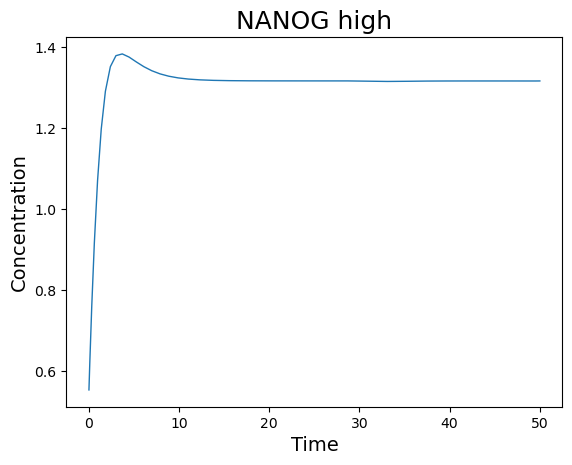

In [12]:
# Plot solution of NANOG :
PyPlot.plot(sol.t, [sol[i][3] for i in 1:length(sol)],
    linewidth=1)
PyPlot.title("NANOG high", fontsize = 18)
PyPlot.xlabel("Time", fontsize = 14)
PyPlot.ylabel("Concentration", fontsize = 14);

In [13]:
# Initial condition for the continuation:
z0 = sol[end];

Now we perform the continuation itself. In the function `ContinuationPar`, the sign on argument `ds` defines the direction of the continuation analysis: growing from its initial value if `ds>0`, or decreasing if `ds<0`.

If a bifurcation point is found, it will be highlighted as **bp** (in blue) in the output:

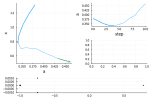

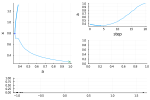

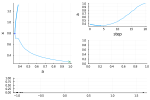

(Branch number of points: 21
Branch of Equilibrium
Parameters a from 0.38 to 1.0
Special points:
 (ind_ev = index of the bifurcating eigenvalue e.g. `br.eig[idx].eigenvals[ind_ev]`)
- #  1,    bp at a ≈ +0.34019068 ∈ (+0.34019068, +0.34019068), |δp|=2e-10, [converged], δ = ( 1,  0), step =   4, eigenelements in eig[  5], ind_ev =   1
, BorderedArray{Vector{Float64}, Float64}([0.15731814770106164, 0.14827637924533346, 0.27817129459123385, 0.05562388447400206, 0.20252534697658675, 0.1723184879996402, 0.14690146250258473, 0.9114458392602344, 2.6020330889133985, 1.893362302348778, 0.0, 0.6469014625025847, 0.20252534697658675], 1.0), BorderedArray{Vector{Float64}, Float64}([0.091964756112568, 0.07676621138867791, 0.15729420474705322, 0.03784369985421612, 0.11309294620207269, 0.08995968172106038, 0.07524924959155137, -0.1319833202769368, -1.129671700255522, -1.0804049653074554, -0.0, 0.07524922364199385, 0.11309294620207269], -0.9349313403161836))

In [14]:
# Continuation options
opts_br = ContinuationPar(pMin = amin, pMax = amax,
    # parameters to have a smooth result
    ds = -0.04, dsmax = 0.05,
    # this is to detect bifurcation points precisely
    detectBifurcation = 3,
    # Optional: bisection options for locating bifurcations
    nInversion = 8, maxBisectionSteps = 25, nev = 3)

# Continuation of equilibria
bra, = continuation(TMvf, dTMvf, z0, param, (@lens _.a), opts_br;
    printSolution = (x, p) -> (NANOG = x[3]),
    tangentAlgo = BorderedPred(),
    plot = true, verbosity = 0, normC = norminf)

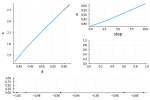

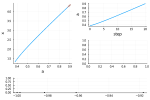

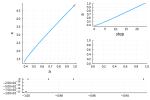

(Branch number of points: 25
Branch of Equilibrium
Parameters a from 0.38 to 1.0
, BorderedArray{Vector{Float64}, Float64}([2.4829780277847497, 1.9829784149233092, 4.869313017572946, 1.9761225774856606, 2.9750410514529766, 1.983140575189127, 0.998918473967316, 0.004590524884417085, 1.4883158582165759, 0.004591299161536291, 0.0, 1.498918473967316, 2.9750410514529766], 1.0), BorderedArray{Vector{Float64}, Float64}([1.17084059167251, 1.1708389002221469, 3.008181699500587, 1.1757656123448428, 1.7524608140591607, 1.1704403082819517, 0.5766953294599656, -0.0066836957618089474, 0.563526320773662, -0.006686633209077327, 0.0, 0.5766953294599656, 1.7524608140591607], 0.5753152516495927))

In [15]:
# Continuation options:
opts_br = ContinuationPar(pMin = amin, pMax = amax,
    # parameters to have a smooth result
    ds = 0.04, dsmax = 0.05,
        # this is to detect bifurcation points precisely
        detectBifurcation = 3,
    # Optional: bisection options for locating bifurcations
    nInversion = 8, maxBisectionSteps = 25, nev = 3)

# Continuation of equilibria:
bra2, = continuation(TMvf, dTMvf, z0, param, (@lens _.a), opts_br;
    printSolution = (x, p) -> (NANOG = x[3]),
    tangentAlgo = BorderedPred(),
    plot = true, verbosity = 0, normC = norminf)

## NANOG low

Now we perform the continuation analysis, just like above, but for the other possible attractor of NANOG (i.e., for low steady-state concentrations).

In [16]:
# Initial conditions on simulations: 
Random.seed!(2135)
xj_2 = rand(Uniform(0,final_ic),13)

# To get the initial condition we need the solution to the system:
prob_low = ODEProblem(TMvf!,xj_2,tspan, param)

sol_low = solve(prob_low);

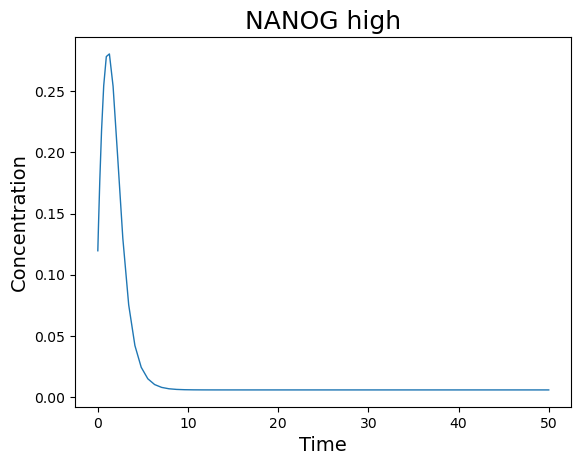

In [17]:
# Plot solution of NANOG :
PyPlot.plot(sol_low.t, [sol_low[i][3] for i in 1:length(sol_low)],
    linewidth=1)
PyPlot.title("NANOG high", fontsize = 18)
PyPlot.xlabel("Time", fontsize = 14)
PyPlot.ylabel("Concentration", fontsize = 14);

In [18]:
# Initial condition for the continuation:
z0 = sol_low[end];

Now we perform the continuation itself. In the function `ContinuationPar`, the sign on argument `ds` defines the direction of the continuation analysis: growing from its initial value if `ds>0`, or decreasing if `ds<0`.

If a bifurcation point is found, it will be highlighted as **bp** (in blue) in the output:

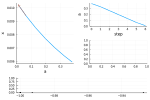

(Branch number of points: 7
Branch of Equilibrium
Parameters a from 0.38 to 0.01
, BorderedArray{Vector{Float64}, Float64}([0.054347531024030414, 8.596267707912723e-8, 0.010242545278555035, 1.2825434449474471e-5, 1.2911397126384824e-5, 8.596267691035302e-8, 8.596267691035296e-8, 0.9993544301436807, 1.814800815007634, 1.0082674812424537, 0.0, 0.5000000859626769, 1.2911397126384824e-5], 0.01), BorderedArray{Vector{Float64}, Float64}([-0.1716777351031426, 1.0852525366010826e-5, -0.021619735962412526, 0.0015789997018998852, 0.001589852227181185, 1.0852525281299098e-5, 1.0852525281299078e-5, 0.0060965384546689885, 1.3042494203862647, 1.1912156998267418, 0.0, 1.0863079577153936e-5, 0.001589852227181185], 1.3257922282642514))

In [19]:
# Continuation options:
opts_br = ContinuationPar(pMin = amin, pMax = amax,
    # parameters to have a smooth result
    ds = -0.04, dsmax = 0.05,
        # this is to detect bifurcation points precisely
        detectBifurcation = 3,
    # Optional: bisection options for locating bifurcations
    nInversion = 8, maxBisectionSteps = 25, nev = 3)

# Continuation of equilibria:
bra3, = continuation(TMvf, dTMvf, z0, param, (@lens _.a), opts_br;
    printSolution = (x, p) -> (NANOG = x[3]),
    tangentAlgo = BorderedPred(),
    plot = true, verbosity = 0, normC = norminf)

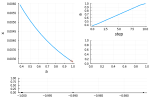

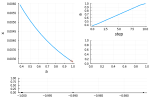

(Branch number of points: 11
Branch of Equilibrium
Parameters a from 0.38 to 1.0
, BorderedArray{Vector{Float64}, Float64}([0.007874214037281968, 1.8161192100833632e-7, 0.0028315109148255692, 3.90578965111112e-6, 4.0874015716428784e-6, 1.8161192053180622e-7, 1.816119205317583e-7, 0.9999979562992142, 2.799891019811564, 1.9842498914484923, 0.0, 0.5000001816119205, 4.0874015716428784e-6], 1.0), BorderedArray{Vector{Float64}, Float64}([-0.015539989202617229, -5.251706166313016e-7, -0.003971236029441219, -1.7985179957167804e-5, -1.851035056784151e-5, -5.251706106741201e-7, -5.251706106737046e-7, 1.1944337381929397e-5, 1.3163276924128045, 1.3261957309061763, 0.0, -5.450114526584878e-7, -1.8510350567841504e-5], 1.3158264796645502))

In [20]:
# Continuation options:
opts_br = ContinuationPar(pMin = amin, pMax = amax,
    # parameters to have a smooth result
    ds = 0.04, dsmax = 0.05,
        # this is to detect bifurcation points precisely
        detectBifurcation = 3,
    # Optional: bisection options for locating bifurcations
    nInversion = 8, maxBisectionSteps = 25, nev = 3)

# Continuation of equilibria:
bra4, = continuation(TMvf, dTMvf, z0, param, (@lens _.a), opts_br;
    printSolution = (x, p) -> (NANOG = x[3]),
    tangentAlgo = BorderedPred(),
    plot = true, verbosity = 0, normC = norminf)

## NANOG full bifurcation

Now we plot the outcome of the bifurcations (4 outputs in total: `bra` and `bra2` for NANOG *high*, and `bra3` and `bra4` for NANOG *low*.

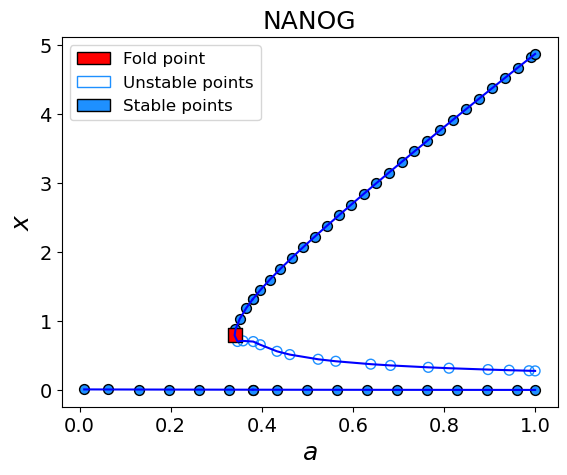

In [21]:
PyPlot.title("NANOG")
PyPlot.plot(bra.param, bra.x, c = "blue")
PyPlot.plot(bra2.param, bra2.x, c = "blue")
PyPlot.plot(bra3.param, bra3.x, c = "blue")
PyPlot.plot(bra4.param, bra4.x, c = "blue")


# Unstable points:
PyPlot.scatter(bra.param[.!bra.stable], 
    bra.x[.!bra.stable],
    c = "None", edgecolors = "dodgerblue",
    s = 50
)
# Stable points:
PyPlot.scatter(bra.param[bra.stable], 
    bra.x[bra.stable],
    c = "dodgerblue", edgecolors = "black",
    s = 50
)
PyPlot.scatter(bra2.param[bra2.stable], 
    bra2.x[bra2.stable],
    c = "dodgerblue", edgecolors = "black",
    s = 50
)
PyPlot.scatter(bra3.param[bra3.stable], 
    bra3.x[bra3.stable],
    c = "dodgerblue", edgecolors = "black",
    s = 50
)
PyPlot.scatter(bra4.param[bra4.stable], 
    bra4.x[bra4.stable],
    c = "dodgerblue", edgecolors = "black",
    s = 50
)

# Fold point:
PyPlot.scatter(bra.param[.!bra.stable][1], 
    bra.x[.!bra.stable][1],
    c = "red", edgecolors = "black",
    marker = "s", s = 100
)

fold_patch = mpatches.Patch(edgecolor="black", facecolor="red", label="Fold point")
unstable_patch = mpatches.Patch(edgecolor="dodgerblue", facecolor="None", label="Unstable points")
stable_patch = mpatches.Patch(edgecolor="black", facecolor="dodgerblue", label="Stable points")

PyPlot.legend(handles=[fold_patch, unstable_patch, stable_patch], fontsize = 12)

PyPlot.title("NANOG", fontsize = 18)
PyPlot.xlabel(L"a", fontsize = 18)
PyPlot.ylabel(L"x", fontsize = 18)
PyPlot.xticks(fontsize = 14)
PyPlot.yticks(fontsize = 14)

PyPlot.show()

PyPlot.savefig("./Results/2_Continuation/a.svg", format="svg")

# Continuation: b <a class="anchor" id="b"></a>

Second, we fix the activation constant to its original value $a=0.38$ and analyze the repression parameter $b$, between 0 and 1, starting from its initial value of $b=0.5$.

In [22]:
bmin = 0.01  # To avoid possible numerical instabilities, we define the lower limit as 0.01 instead of 0
bmax = 1.;

Again, since the system is bistable, we need two initial conditions for the continuation analysis: one for the case that NANOG is in a *high* steady-state of concentration, and another one for when NANOG is *low*.

These are the same as for the continuation of $a$: `sol` for NANOG *high*, and `sol_low` for NANOG *low*.

## b NANOG high

In [23]:
# Initial condition for the continuation analysis:
z0 = sol[end];

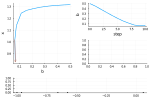

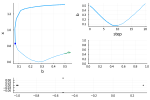

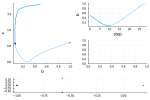

┌ Warning: Bisection failed to locate bifurcation point precisely around p = 0.06802768042163825. Fall back to original guess for the bifurcation point. Number of Bisections = 7
└ @ BifurcationKit /home/guillermo/.julia/packages/BifurcationKit/uBOAa/src/Bifurcations.jl:275


(Branch number of points: 29
Branch of Equilibrium
Parameters b from 0.5 to 1.0
Special points:
 (ind_ev = index of the bifurcating eigenvalue e.g. `br.eig[idx].eigenvals[ind_ev]`)
- #  1,    bp at b ≈ +0.06802768 ∈ (+0.06312669, +0.06802768), |δp|=5e-03, [    guess], δ = ( 1,  0), step =  10, eigenelements in eig[ 11], ind_ev =   1
, BorderedArray{Vector{Float64}, Float64}([0.4581270685408122, 0.36844844922569153, 0.845307722712179, 0.2738155350952957, 0.5886587259246239, 0.423443227245691, 0.3148431908293282, 0.7366876591887866, 1.77869790589853, 1.0826097838490407, 0.0, 1.314843190829328, 0.5886587259246239], 1.0), BorderedArray{Vector{Float64}, Float64}([-0.05093255998712978, -0.09909413175223815, -0.27042828821963866, -0.0937277854465948, -0.1455396299900789, -0.11439372632918476, -0.051811844543484024, -0.5942603754873655, -0.5976755248673926, -0.6501498165775812, -0.0, -1.1548169087668556, -0.1455396299900789], -1.1030049729603306))

In [24]:
# Continuation options:
opts_br = ContinuationPar(pMin = 0.01, pMax = bmax,
    # parameters to have a smooth result
    ds = -0.04, dsmax = 0.05,
        # this is to detect bifurcation points precisely
        detectBifurcation = 3,
    # Optional: bisection options for locating bifurcations
    nInversion = 8, maxBisectionSteps = 25, nev = 3)

# Continuation of equilibria:
brb, = continuation(TMvf, dTMvf, z0, param, (@lens _.b), opts_br;
    printSolution = (x, p) -> (NANOG = x[3]),
    tangentAlgo = BorderedPred(),
    plot = true, verbosity = 0, normC = norminf)

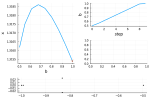

(Branch number of points: 10
Branch of Equilibrium
Parameters b from 0.5 to 1.0
, BorderedArray{Vector{Float64}, Float64}([1.6015882784597009, 0.6061990247513316, 1.3153451440809454, 0.6121924596372653, 0.9724067438569136, 0.6036275429613125, 0.36021428421964824, 0.08159609180197532, 1.613278564721046, 0.08334817539279503, 0.0, 1.3602142842196483, 0.9724067438569136], 1.0), BorderedArray{Vector{Float64}, Float64}([1.266254841288807, 0.012488045891142491, -0.018487729501222915, 0.031235601309466926, 0.030444751148442112, 0.004616315618848403, -0.0007908501610248133, 0.037428759819609476, 1.395649848256233, 0.03993563999826579, 0.0, 1.2654111465892144, 0.030444751148442112], 1.2662018919842253))

In [25]:
# Continuation options:
opts_br = ContinuationPar(pMin = 0.01, pMax = bmax,
    # parameters to have a smooth result
    ds = 0.04, dsmax = 0.05,
        # this is to detect bifurcation points precisely
        detectBifurcation = 3,
    # Optional: bisection options for locating bifurcations
    nInversion = 8, maxBisectionSteps = 25, nev = 3)

# Continuation of equilibria:
brb2, = continuation(TMvf, dTMvf, z0, param, (@lens _.b), opts_br;
    printSolution = (x, p) -> (NANOG = x[3]),
    tangentAlgo = BorderedPred(),
    plot = true, verbosity = 0, normC = norminf)

## b NANOG low

In [26]:
# Initial condition for the continuation analysis:
z0 = sol_low[end];

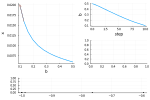

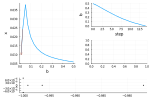

(Branch number of points: 15
Branch of Equilibrium
Parameters b from 0.5 to 0.01
, BorderedArray{Vector{Float64}, Float64}([0.01000239113346972, 3.033422759181604e-6, 0.00999280950231419, 3.042156880571184e-6, 6.075579639667199e-6, 3.0334227591808688e-6, 3.0334227590960147e-6, 0.019999840116325274, 0.05038762907738831, 0.020024247109324742, 0.0, 0.010003033422759097, 6.075579639667199e-6], 0.01), BorderedArray{Vector{Float64}, Float64}([0.6996898159392391, 0.0006347206919032881, 0.6969787468315447, 0.0006384120913477398, 0.001273132783197144, 0.0006347206919026692, 0.0006347206918494042, 1.3984254302278831, 3.5786224705740795, 1.4035573706900764, 0.0, 0.6998697775688205, 0.001273132783197144], 0.6992350572450179))

In [27]:
# Continuation options:
opts_br = ContinuationPar(pMin = 0.01, pMax = bmax,
    # parameters to have a smooth result
    ds = -0.04, dsmax = 0.05,
        # this is to detect bifurcation points precisely
        detectBifurcation = 3,
    # Optional: bisection options for locating bifurcations
    nInversion = 8, maxBisectionSteps = 25, nev = 3)

# Continuation of equilibria:
brb3, = continuation(TMvf, dTMvf, z0, param, (@lens _.b), opts_br;
    printSolution = (x, p) -> (NANOG = x[3]),
    tangentAlgo = BorderedPred(),
    plot = true, verbosity = 0, normC = norminf)

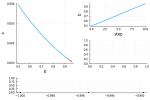

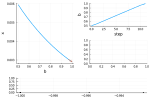

(Branch number of points: 12
Branch of Equilibrium
Parameters b from 0.5 to 1.0
, BorderedArray{Vector{Float64}, Float64}([0.009227436972782008, 7.366042053282473e-8, 0.002893700677072036, 2.388437577249388e-6, 2.4620979977407925e-6, 7.366042049140607e-8, 7.366042049140487e-8, 1.9999935207947428, 3.505389794419578, 2.3764871227360453, 0.0, 1.0000000736604204, 2.4620979977407925e-6], 1.0), BorderedArray{Vector{Float64}, Float64}([-0.013035302498597561, -2.8455375456320597e-7, -0.00372616805063166, -1.0122147644251734e-5, -1.0406701398288325e-5, -2.845537540366025e-7, -2.8455375403658844e-7, 1.8680038939423855, 2.603400943780168, 1.876232250069721, 0.0, 0.9339909765109825, -1.040670139828832e-5], 0.9339911837859597))

In [28]:
# Continuation options:
opts_br = ContinuationPar(pMin = 0.01, pMax = bmax,
    # parameters to have a smooth result
    ds = 0.04, dsmax = 0.05,
        # this is to detect bifurcation points precisely
        detectBifurcation = 3,
    # Optional: bisection options for locating bifurcations
    nInversion = 8, maxBisectionSteps = 25, nev = 3)

# Continuation of equilibria:
brb4, = continuation(TMvf, dTMvf, z0, param, (@lens _.b), opts_br;
    printSolution = (x, p) -> (NANOG = x[3]),
    tangentAlgo = BorderedPred(),
    plot = true, verbosity = 0, normC = norminf)

## b NANOG full bifurcation

Now we plot the outcome of the bifurcations (4 outputs in total: `brb` and `brb2` for NANOG *high*, and `brb3` and `brb4` for NANOG *low*.

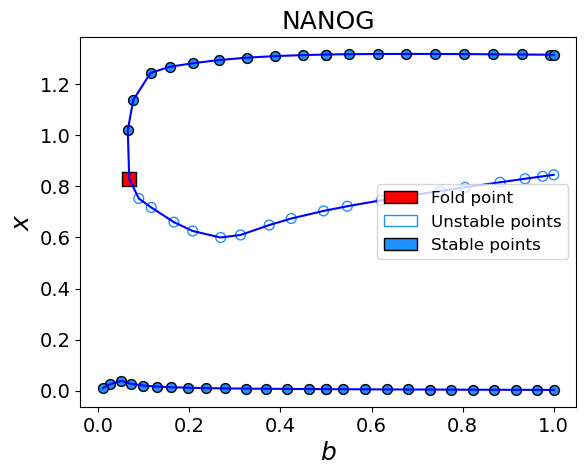

In [29]:
PyPlot.title("NANOG")
PyPlot.xlabel("b")
PyPlot.plot(brb.param, brb.x, c = "blue")
PyPlot.plot(brb2.param, brb2.x, c = "blue")
PyPlot.plot(brb3.param, brb3.x, c = "blue")
PyPlot.plot(brb4.param, brb4.x, c = "blue")


# Unstable points:
PyPlot.scatter(brb.param[.!brb.stable], 
    brb.x[.!brb.stable],
    c = "None", edgecolors = "dodgerblue",
    s = 50
)
# Stable points:
PyPlot.scatter(brb.param[brb.stable], 
    brb.x[brb.stable],
    c = "dodgerblue", edgecolors = "black",
    s = 50
)
PyPlot.scatter(brb2.param[brb2.stable], 
    brb2.x[brb2.stable],
    c = "dodgerblue", edgecolors = "black",
    s = 50
)
PyPlot.scatter(brb3.param[brb3.stable], 
    brb3.x[brb3.stable],
    c = "dodgerblue", edgecolors = "black",
    s = 50
)
PyPlot.scatter(brb4.param[brb4.stable], 
    brb4.x[brb4.stable],
    c = "dodgerblue", edgecolors = "black",
    s = 50
)

# Fold point:
PyPlot.scatter(brb.param[.!brb.stable][1], 
    brb.x[.!brb.stable][1],
    c = "red", edgecolors = "black",
    marker = "s", s = 100
)

fold_patch = mpatches.Patch(edgecolor="black", facecolor="red", label="Fold point")
unstable_patch = mpatches.Patch(edgecolor="dodgerblue", facecolor="None", label="Unstable points")
stable_patch = mpatches.Patch(edgecolor="black", facecolor="dodgerblue", label="Stable points")

PyPlot.legend(handles=[fold_patch, unstable_patch, stable_patch], fontsize = 12)

PyPlot.title("NANOG", fontsize = 18)
PyPlot.xlabel(L"b", fontsize = 18)
PyPlot.ylabel(L"x", fontsize = 18)
PyPlot.xticks(fontsize = 14)
PyPlot.yticks(fontsize = 14)

PyPlot.show()

PyPlot.savefig("./Results/2_Continuation/b.svg", format="svg")